In [1]:
import torch
from torchvision.utils import make_grid
from PIL import Image
from einops import rearrange
from diffusers.models import AutoencoderKL
from mean_flow import MeanFlow, DiT_models

In [20]:
seed = 42
image_size = 256
num_classes = 1000
model_path = "/data/results/MeanFlow/DiT-B-4_256/000-DiT-B-4/checkpoints/0080000.pt"
device = "cuda"
class_labels = [281, 360, 387, 974, 88, 979, 417, 279]
cfg_scale = 3.0
steps = 1

In [8]:
vae = AutoencoderKL.from_pretrained("/data/sd-vae-ft-mse").to(device)
model = DiT_models["DiT-B/4"](input_size=image_size//8, num_classes=num_classes).to(device)
state_dict = torch.load(model_path, map_location=device)["ema"]
model.load_state_dict(state_dict)
model.eval()

/tmp/ipykernel_506692/905398362.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)["ema"]


DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(4, 4), stride=(4, 4))
    (norm): Identity()
  )
  (r_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 768)
  )
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear

In [27]:
n = len(class_labels)
timesteps = torch.linspace(1, 0, steps+1, dtype=torch.float32)
z = torch.randn(n, 4, image_size//8, image_size//8, device=device)
y = torch.tensor(class_labels, device=device)

In [28]:
with torch.no_grad():
    for i in range(steps):
        t = torch.full((n, ), timesteps[i], device=device)
        r = torch.full((n, ), timesteps[i+1], device=device)
        t_ = rearrange(t, "b -> b 1 1 1").detach().clone()
        r_ = rearrange(r, "b -> b 1 1 1").detach().clone()
        u = model(z, r, t, y)
        z = z - (t_ - r_) * u
    images = vae.decode(z / 0.18215).sample

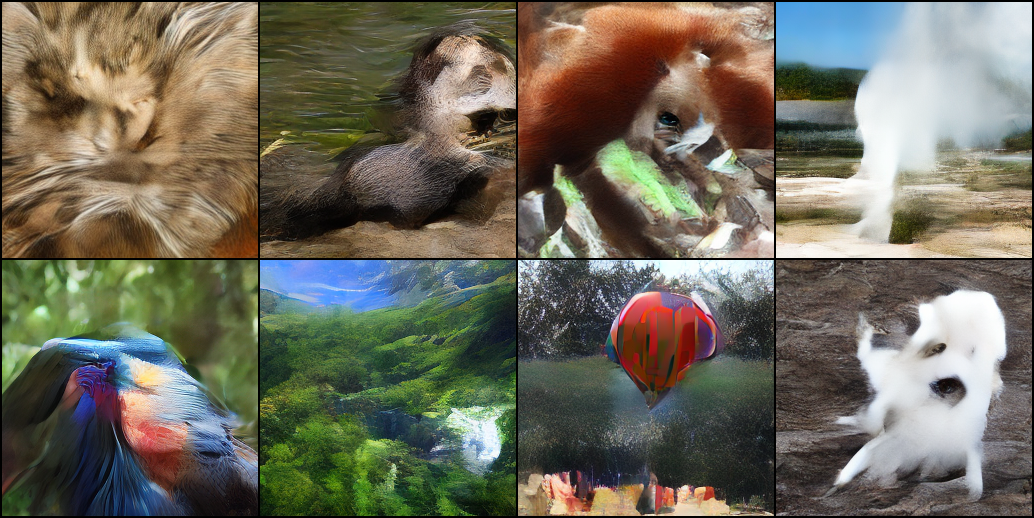

In [29]:
grid = make_grid(images, nrow=4, normalize=True, value_range=(-1, 1))
grid = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
Image.fromarray(grid)